In [1]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Make sure the path to your zip file on Google Drive is correct.
!unzip "/content/drive/MyDrive/Spine Images and Data.zip" -d /content/source_data/

Streaming output truncated to the last 5000 lines.
  inflating: /content/source_data/Spine Images and Data/spine000622/spine_info000622.txt  
  inflating: /content/source_data/__MACOSX/Spine Images and Data/spine000622/._spine_info000622.txt  
  inflating: /content/source_data/Spine Images and Data/spine000622/spine_bounding_boxes000622.csv  
  inflating: /content/source_data/__MACOSX/Spine Images and Data/spine000622/._spine_bounding_boxes000622.csv  
  inflating: /content/source_data/Spine Images and Data/spine000622/spine_bounding_boxes000622.txt  
  inflating: /content/source_data/Spine Images and Data/spine000622/spine_image000622.tif  
  inflating: /content/source_data/__MACOSX/Spine Images and Data/spine000622/._spine_image000622.tif  
  inflating: /content/source_data/Spine Images and Data/spine000410/spine_image000410.tif  
  inflating: /content/source_data/__MACOSX/Spine Images and Data/spine000410/._spine_image000410.tif  
  inflating: /content/source_data/Spine Images and D

In [4]:
import os
import shutil
import cv2
import random

# --- Configuration ---
source_base_dir = "/content/source_data/Spine Images and Data"
target_dataset_dir = "/content/yolo_dataset"
IMAGE_WIDTH = 416.0
IMAGE_HEIGHT = 416.0
BOX_PIXEL_WIDTH = 40.96
BOX_PIXEL_HEIGHT = 40.96
train_split_ratio = 0.8 # This ratio will re-split the data
# --- End of Configuration ---

# --- Setup Target Directories ---
train_image_path = os.path.join(target_dataset_dir, "images", "train")
val_image_path = os.path.join(target_dataset_dir, "images", "val")
train_label_path = os.path.join(target_dataset_dir, "labels", "train")
val_label_path = os.path.join(target_dataset_dir, "labels", "val")

if os.path.exists(target_dataset_dir):
    shutil.rmtree(target_dataset_dir)
os.makedirs(train_image_path, exist_ok=True)
os.makedirs(val_image_path, exist_ok=True)
os.makedirs(train_label_path, exist_ok=True)
os.makedirs(val_label_path, exist_ok=True)

print("Created new clean target directory structure.")

# --- Conversion Formulas ---
def convert_to_yolo(x_in, y_in, box_w, box_h, img_w, img_h, mode):
    norm_w = box_w / img_w
    norm_h = box_h / img_h
    if mode == 'corner':
        x_center_pixel = x_in + box_w / 2.0
        y_center_pixel = y_in + box_h / 2.0
        norm_x_center = x_center_pixel / img_w
        norm_y_center = y_center_pixel / img_h
    else: # mode is 'center'
        norm_x_center = x_in / img_w
        norm_y_center = y_in / img_h
    norm_x_center = max(0.0, min(1.0, norm_x_center))
    norm_y_center = max(0.0, min(1.0, norm_y_center))
    norm_w = max(0.0, min(1.0, norm_w))
    norm_h = max(0.0, min(1.0, norm_h))
    return norm_x_center, norm_y_center, norm_w, norm_h

# --- Processing Logic ---
processed_count = 0
for folder_name in os.listdir(source_base_dir):
    folder_path = os.path.join(source_base_dir, folder_name)

    if os.path.isdir(folder_path):
        image_file = None
        label_source_file = None
        for file in os.listdir(folder_path):
            file_lower = file.lower()
            if file_lower.endswith((".tif", ".tiff", ".png", ".jpg")):
                image_file = file
            elif "bounding_boxes" in file_lower and file_lower.endswith(".txt"):
                label_source_file = file

        if image_file and label_source_file:
            source_label_filepath = os.path.join(folder_path, label_source_file)
            yolo_label_lines = []
            try:
                with open(source_label_filepath, 'r') as f:
                    for line in f:
                        parts = line.strip().split(',')
                        if len(parts) == 4:
                            x_pixel, y_pixel = float(parts[0]), float(parts[1])
                            mode = 'center'
                            norm_x, norm_y, norm_w, norm_h = convert_to_yolo(
                                x_pixel, y_pixel, BOX_PIXEL_WIDTH, BOX_PIXEL_HEIGHT,
                                IMAGE_WIDTH, IMAGE_HEIGHT, mode=mode
                            )
                            yolo_label_lines.append(f"0 {norm_x:.6f} {norm_y:.6f} {norm_w:.6f} {norm_h:.6f}\n")
            except Exception as e:
                print(f"Error reading or parsing {source_label_filepath}: {e}")
                continue

            if random.random() < train_split_ratio:
                dest_image_dir, dest_label_dir = train_image_path, train_label_path
            else:
                dest_image_dir, dest_label_dir = val_image_path, val_label_path

            base_filename = os.path.splitext(image_file)[0]
            new_label_filepath = os.path.join(dest_label_dir, f"{base_filename}.txt")
            with open(new_label_filepath, 'w') as f:
                f.writelines(yolo_label_lines)

            source_image_filepath = os.path.join(folder_path, image_file)
            new_image_filepath = os.path.join(dest_image_dir, f"{base_filename}.png")
            try:
                image_data = cv2.imread(source_image_filepath)
                if image_data is not None:
                    cv2.imwrite(new_image_filepath, image_data)
                    processed_count += 1
            except Exception as e:
                print(f"Error converting image {source_image_filepath}: {e}")

print(f"\nConversion complete. Processed {processed_count} image/label pairs.")

Created new clean target directory structure.

Conversion complete. Processed 1836 image/label pairs.


In [21]:
import yaml

data_config = {
    'train': '/content/yolo_dataset/images/train',
    'val': '/content/yolo_dataset/images/val',
    'nc': 1,
    'names': ['dendritic_spine']
}

with open('/content/dendrites.yaml', 'w') as f:
    yaml.dump(data_config, f, sort_keys=False)

print("dendrites.yaml file created successfully.")

dendrites.yaml file created successfully.


In [22]:
!yolo train model=yolov9m.pt data=/content/dendrites.yaml epochs=100 imgsz=416 project=DendriticSpineDetection name=final_run

Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dendrites.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov9m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=final_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=1

--- Confusion Matrix ---


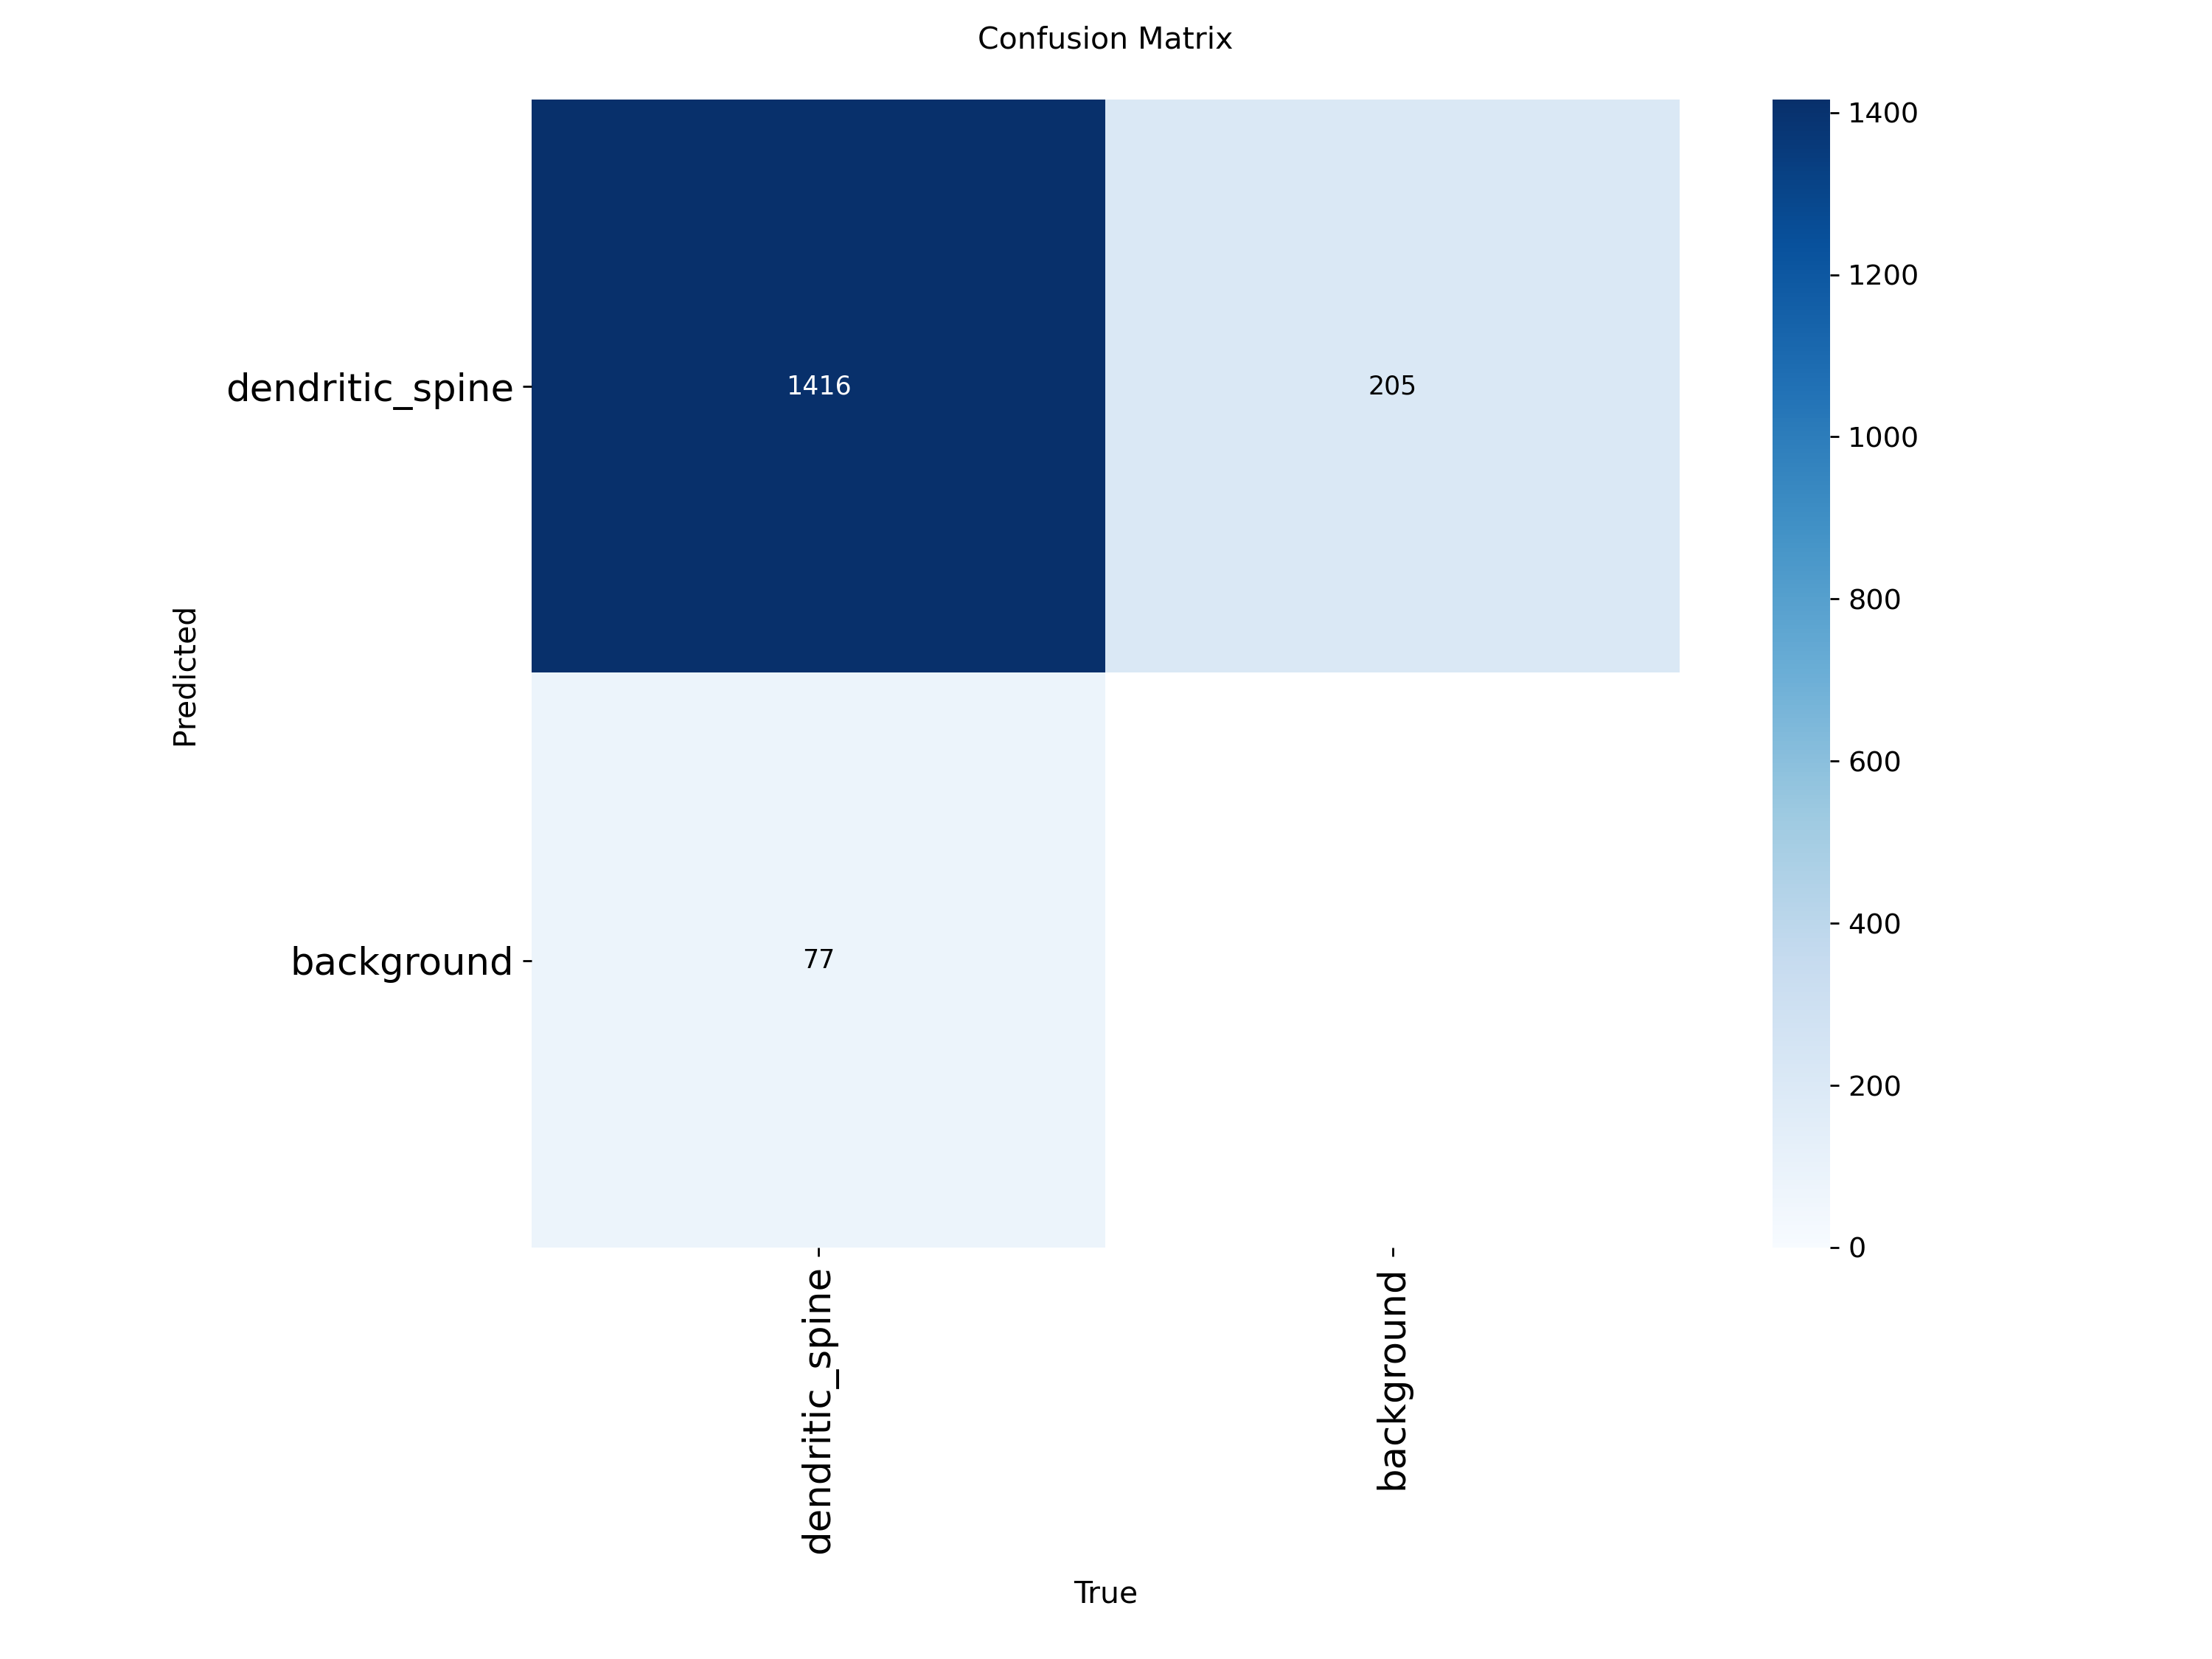


--- Performance Charts ---


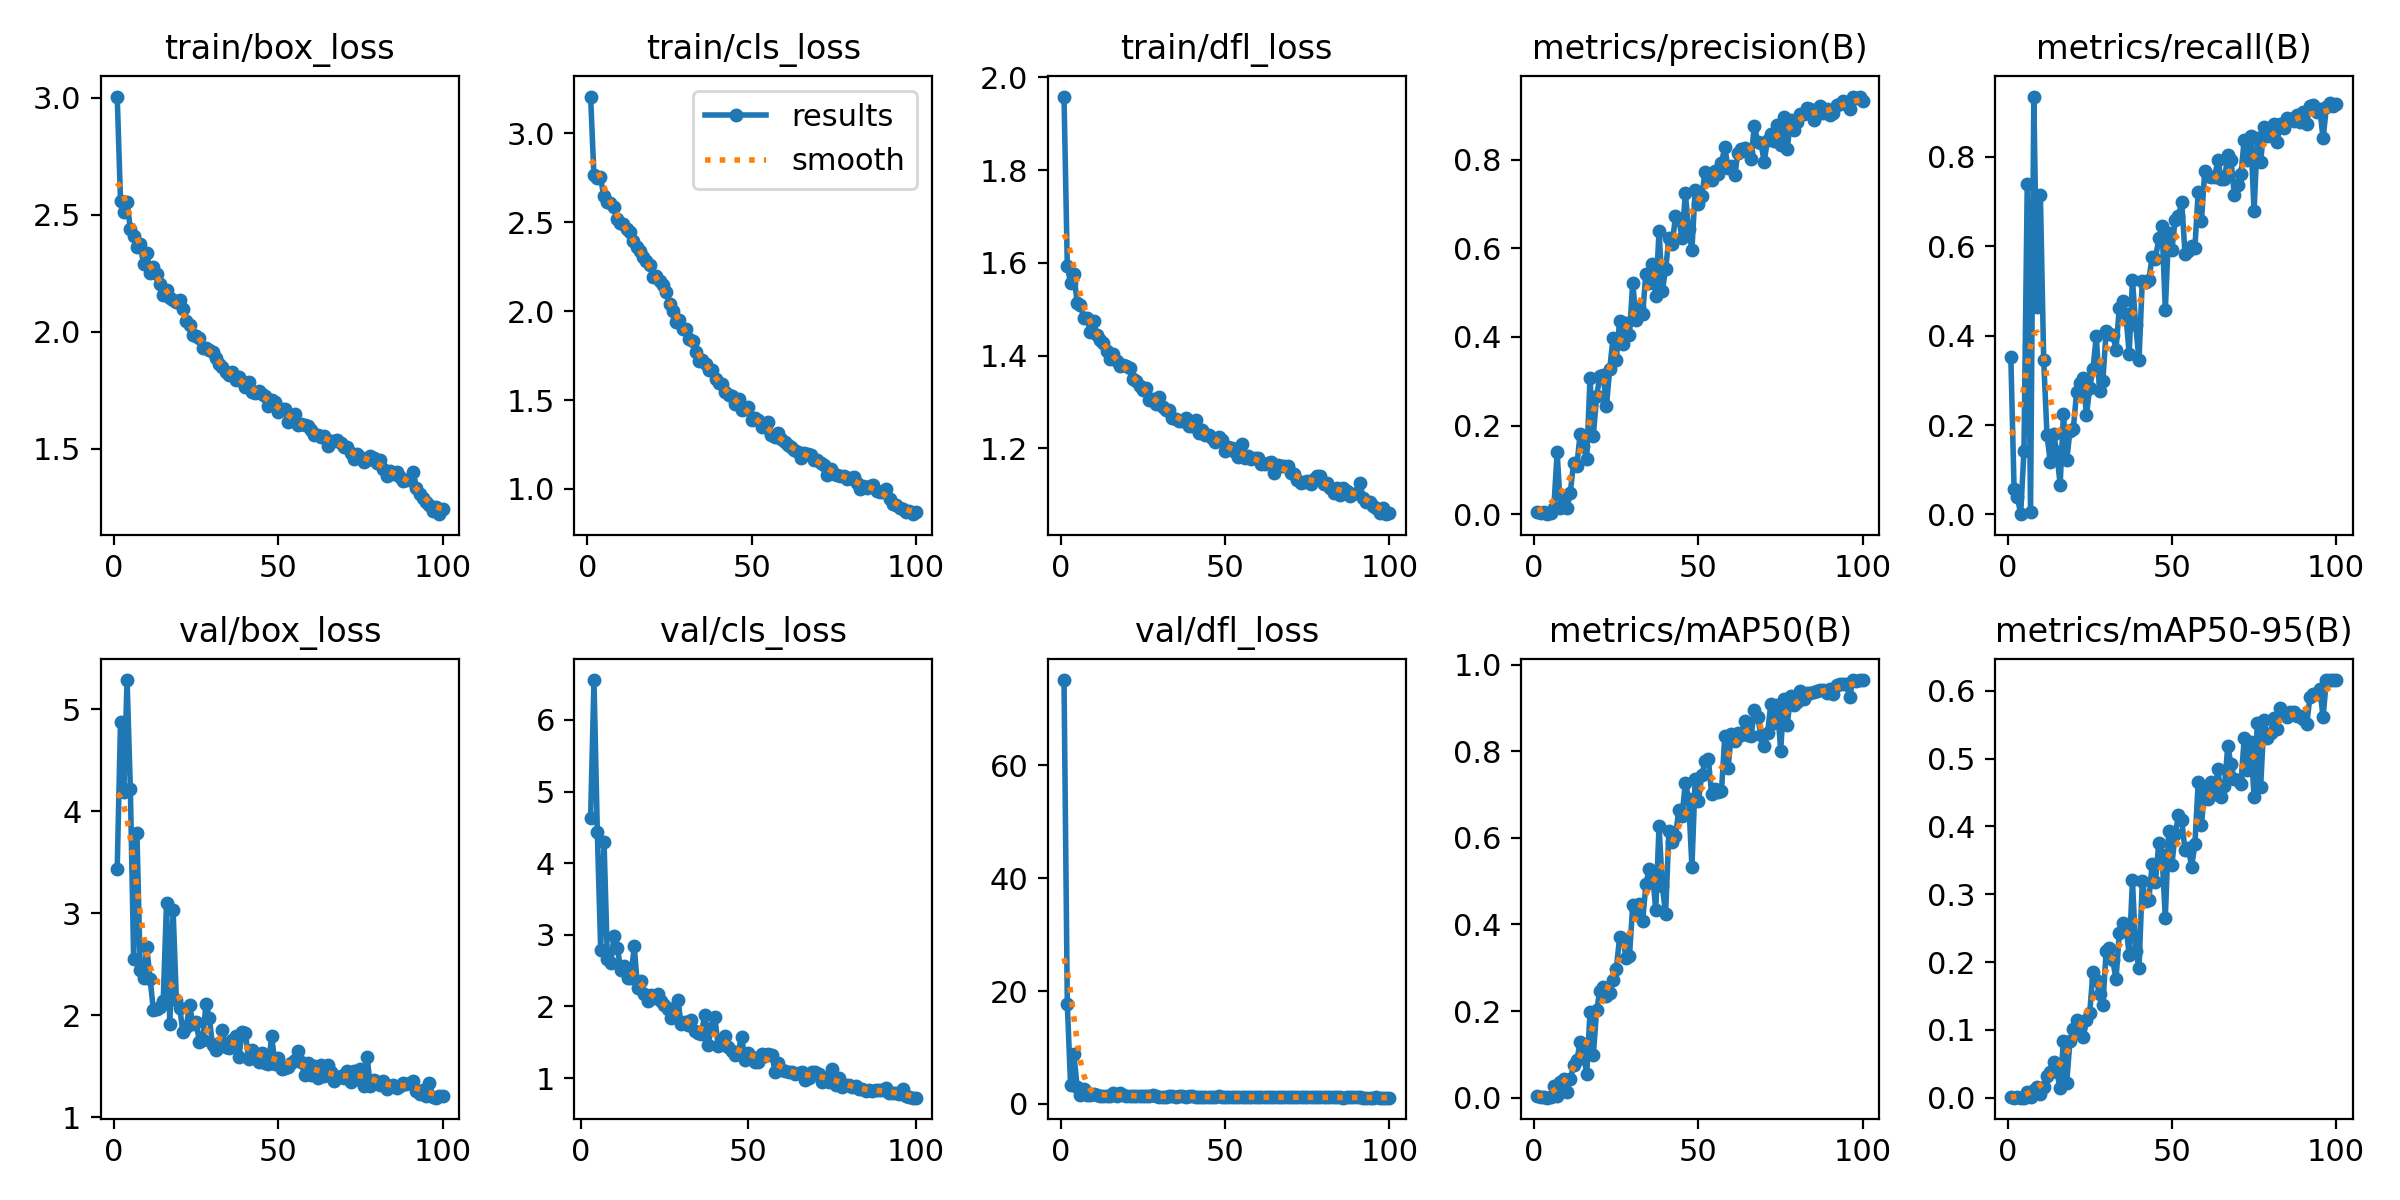

In [23]:
from IPython.display import Image, display

# Path to the new results folder
results_path = "/content/DendriticSpineDetection/final_run"

print("--- Confusion Matrix ---")
display(Image(filename=f"{results_path}/confusion_matrix.png"))

print("\n--- Performance Charts ---")
display(Image(filename=f"{results_path}/results.png"))

--- Confusion Matrix ---


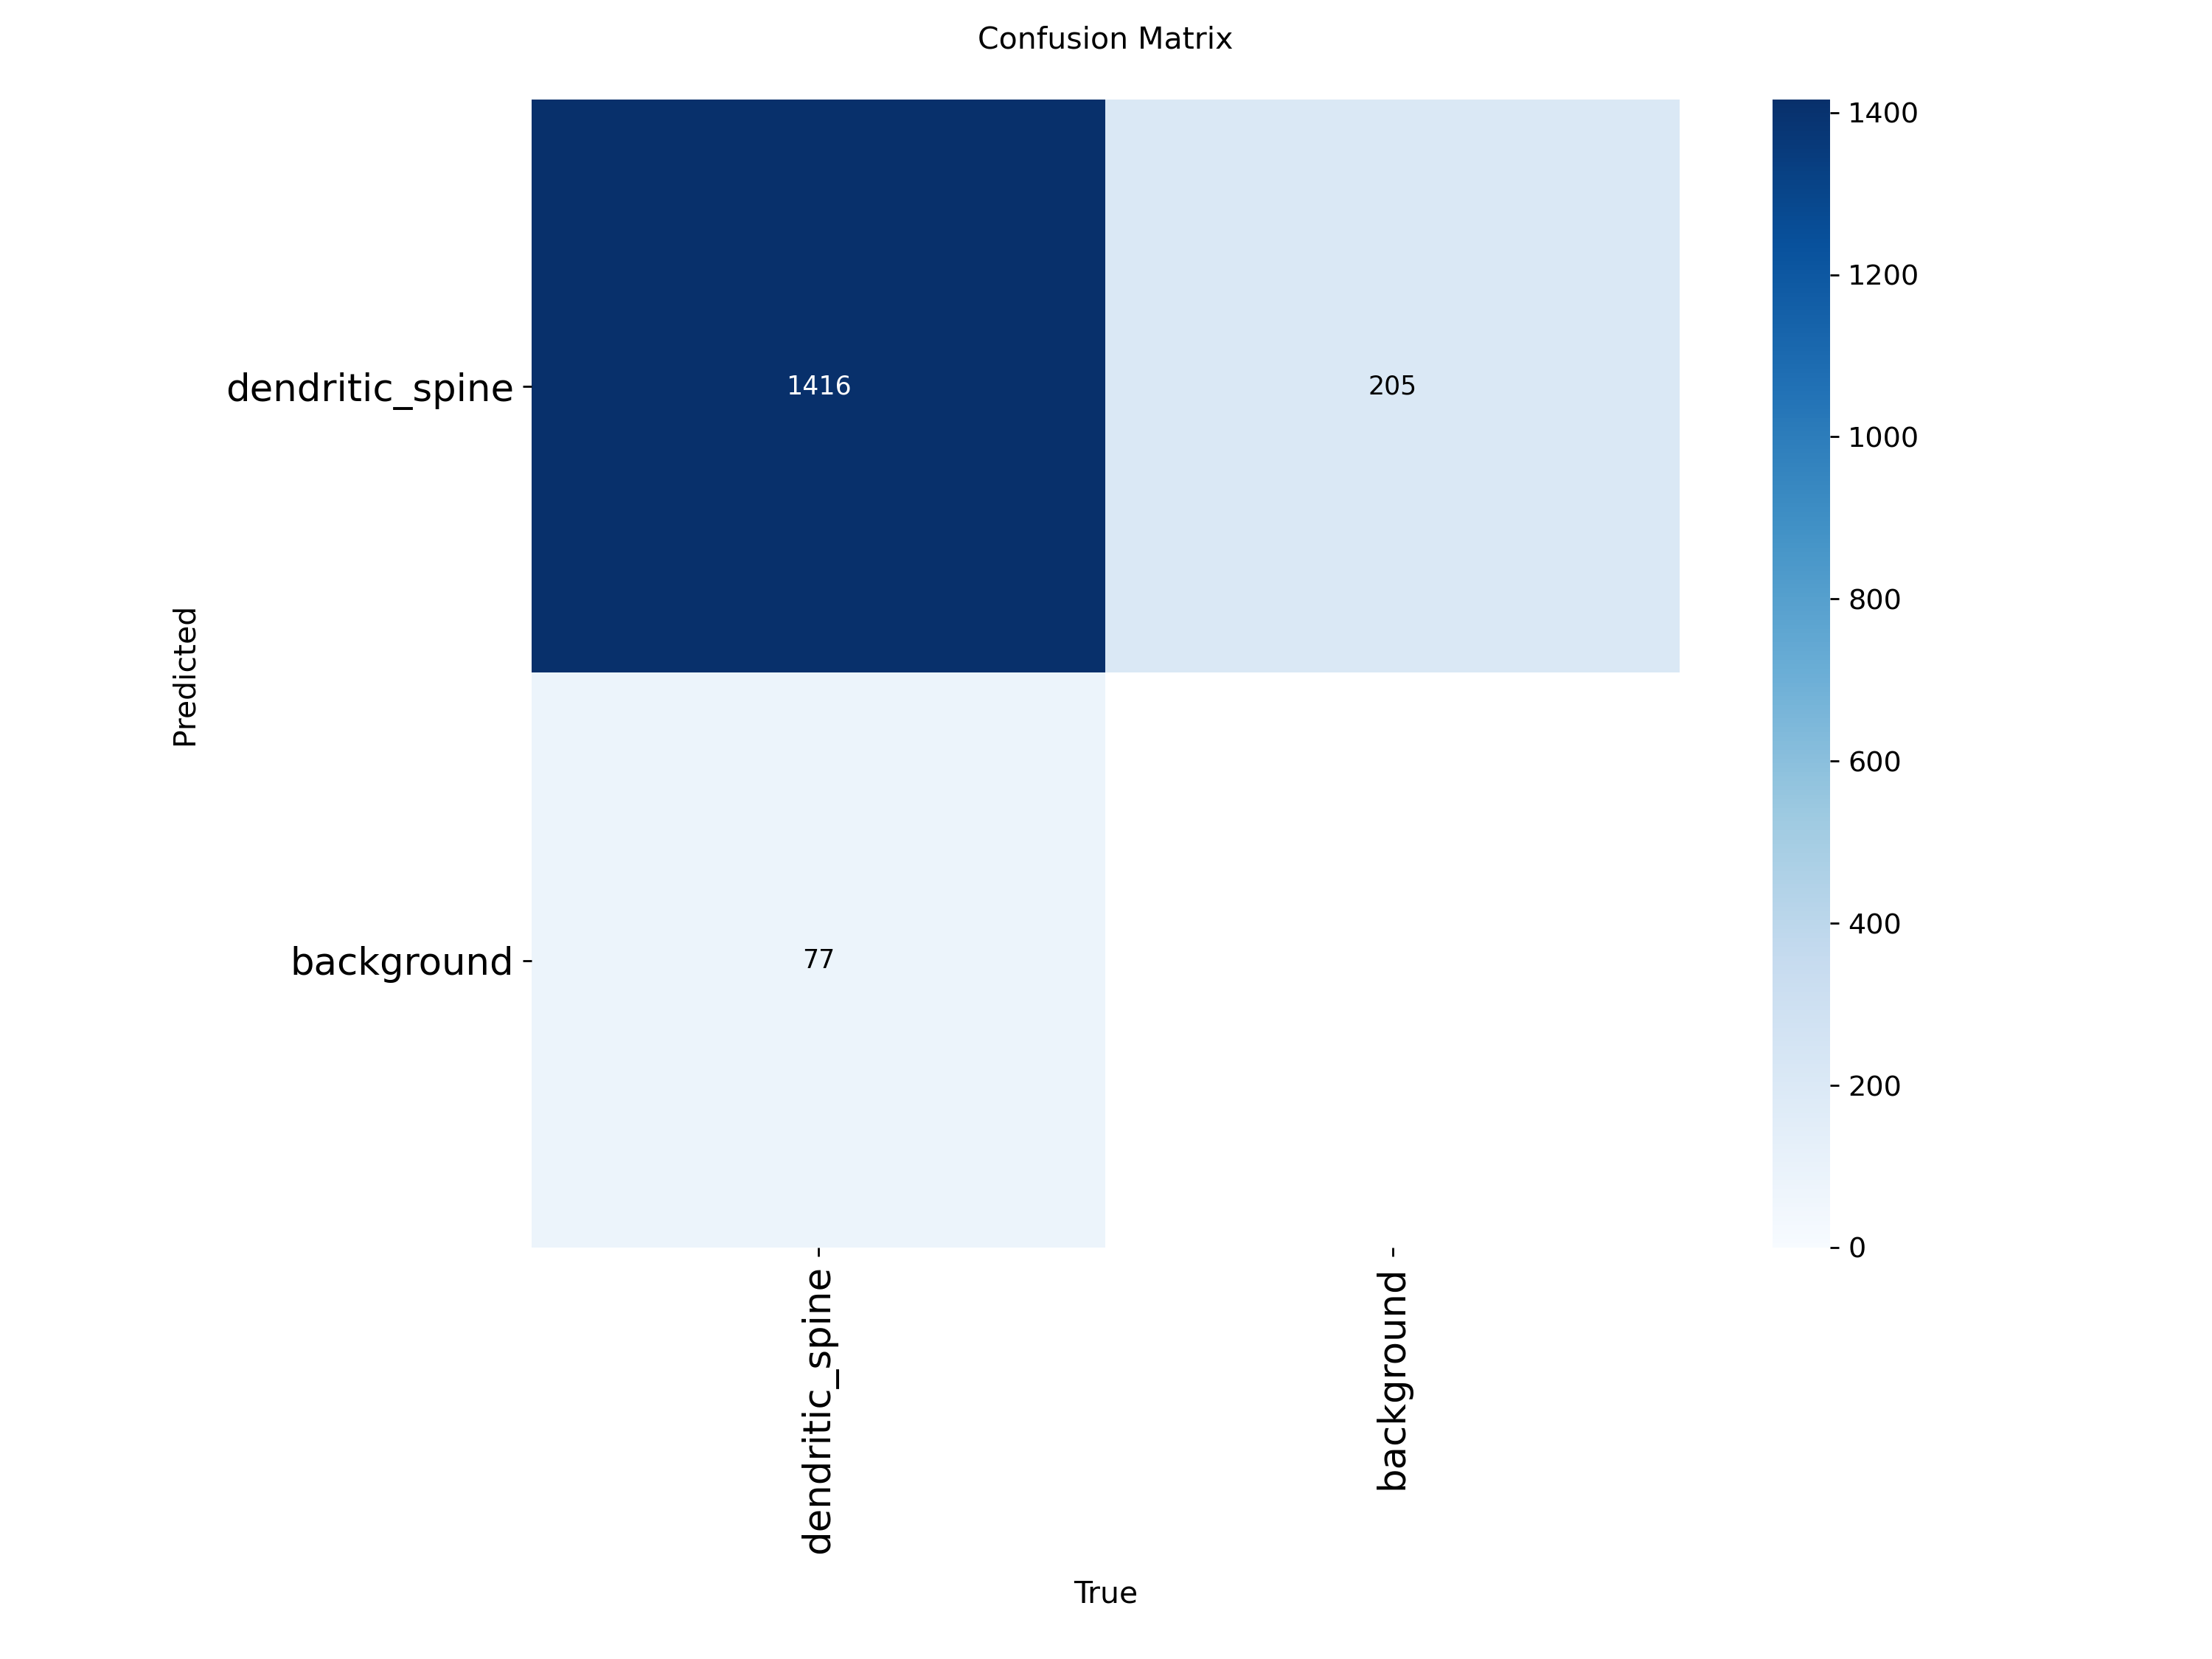


--- Confusion Matrix ---


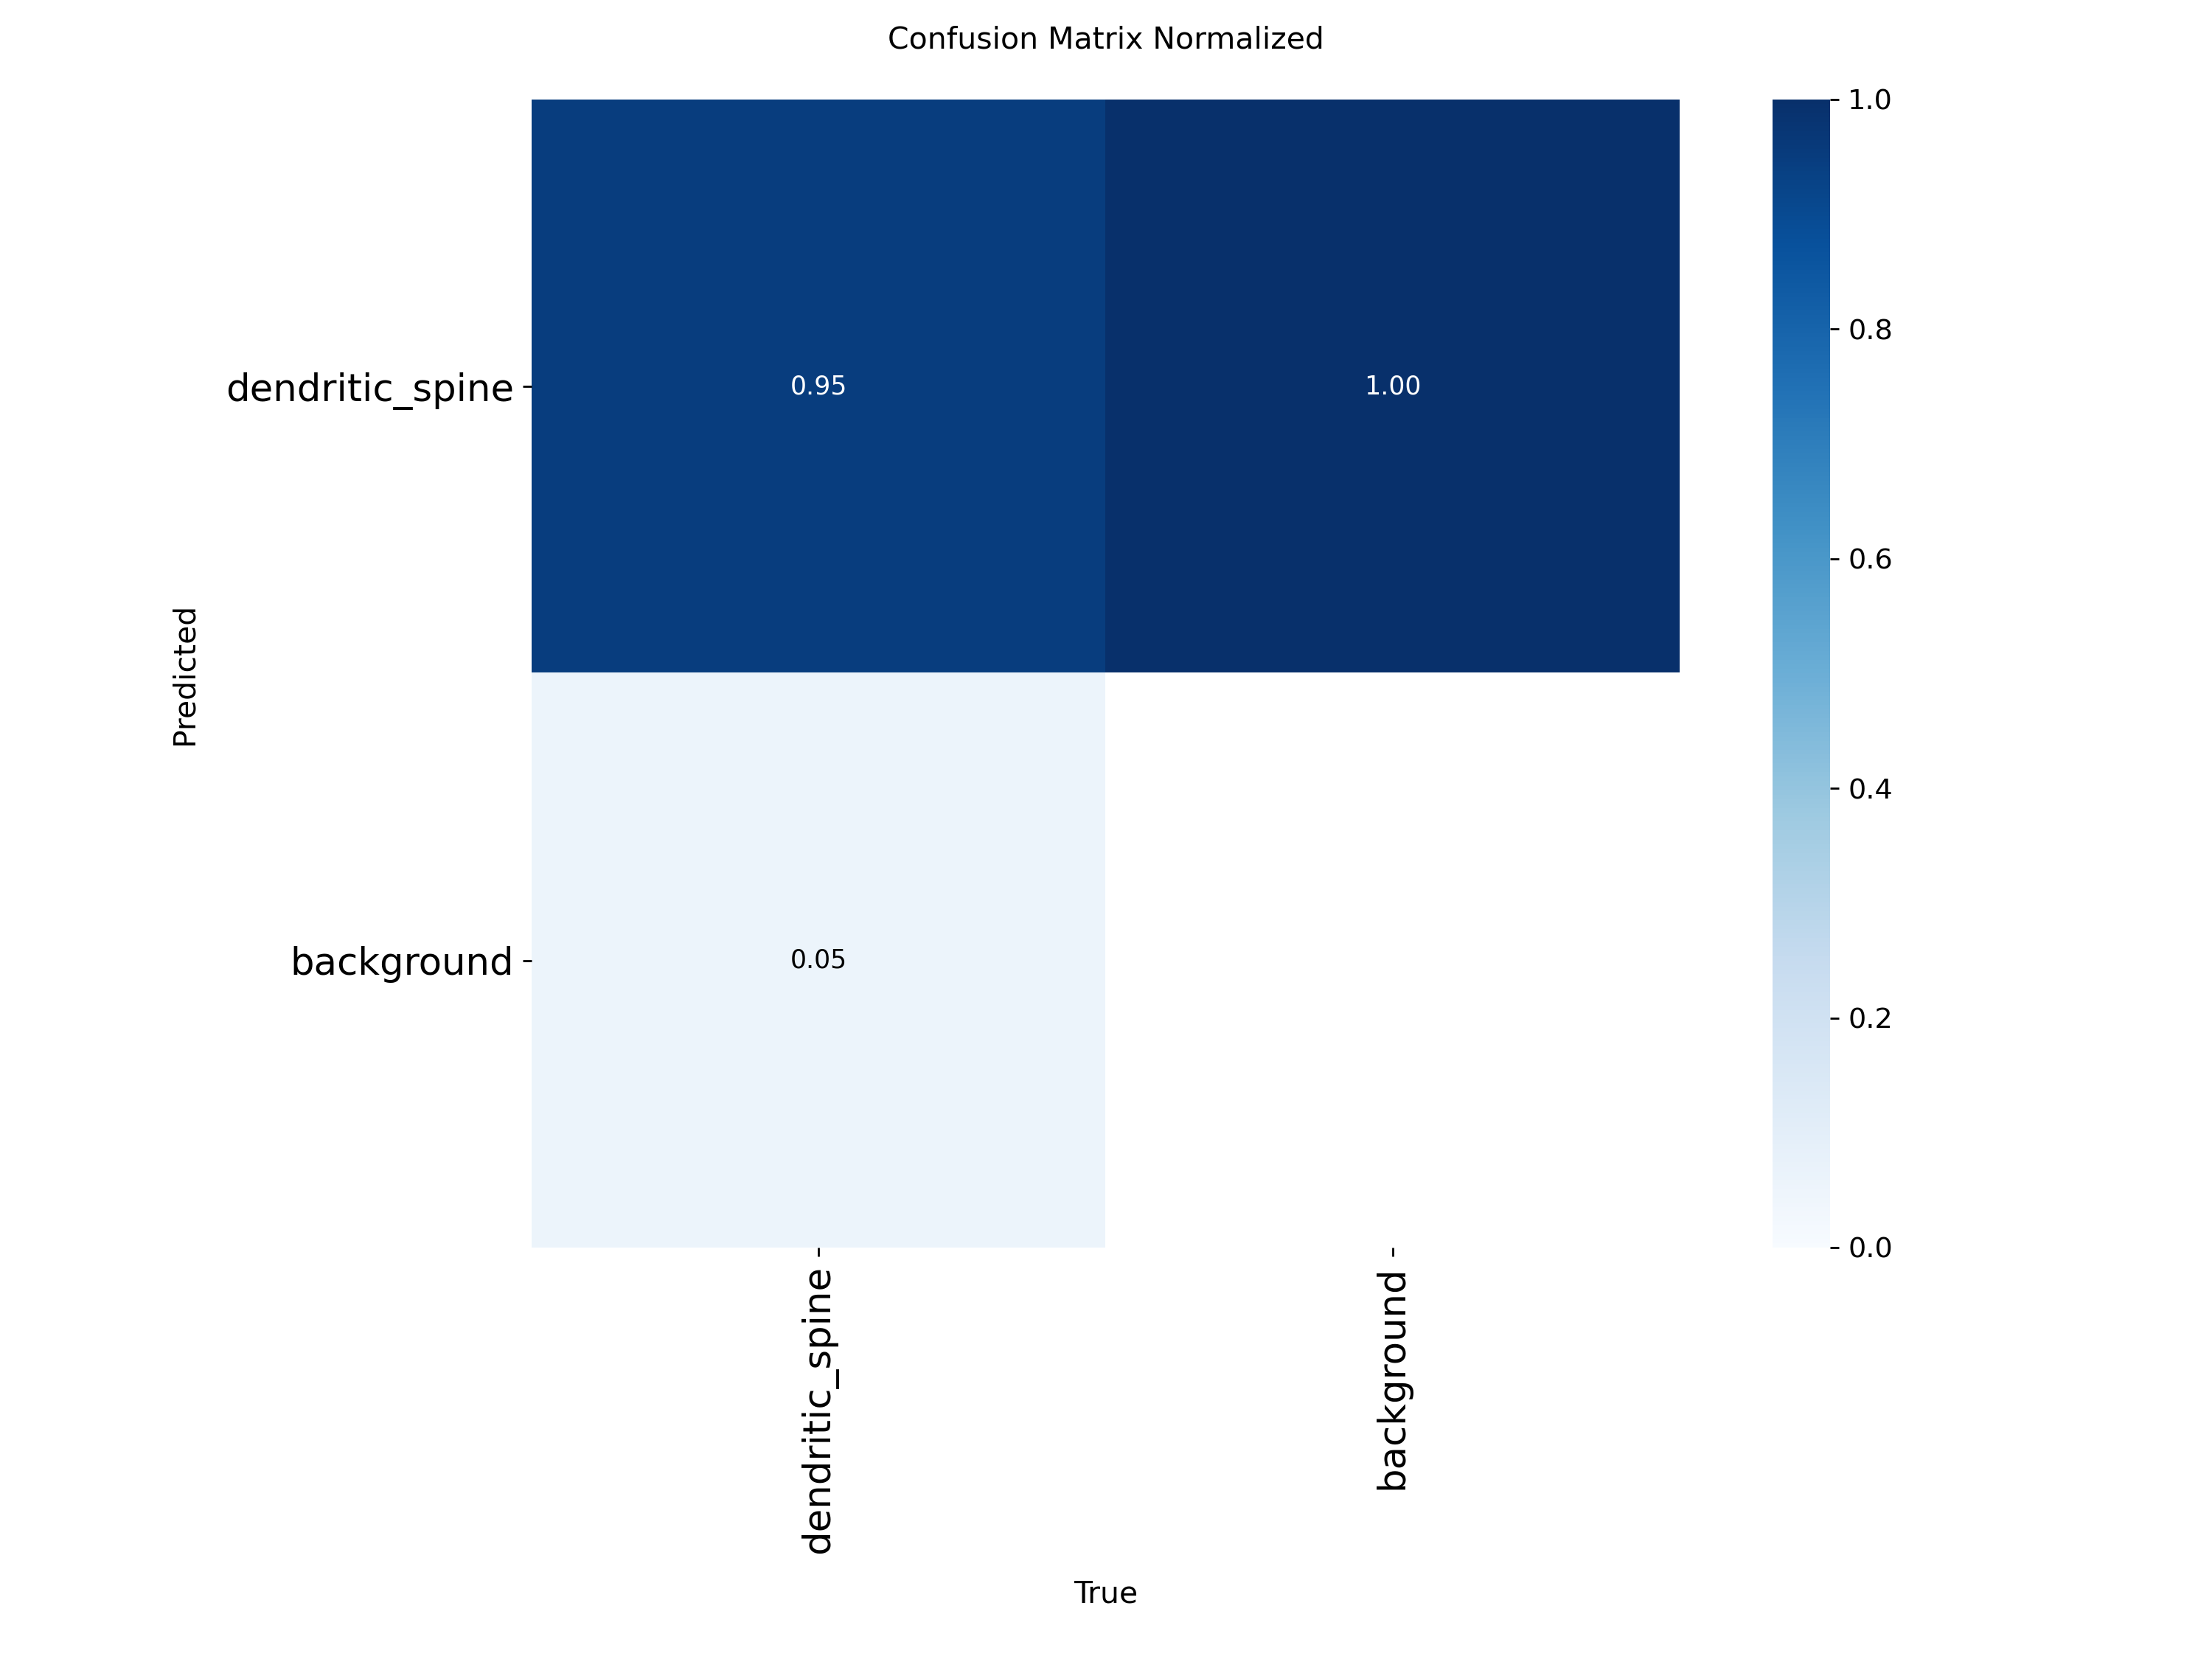

In [28]:
from IPython.display import Image, display

# --- Update this with the folder name from Step 1 ---
results_folder_name = "final_run"
# ----------------------------------------------------

base_path = f"/content/DendriticSpineDetection/{results_folder_name}"
standard_matrix = f"{base_path}/confusion_matrix.png"
normalized_matrix = f"{base_path}/confusion_matrix_normalized.png"

print("--- Confusion Matrix ---")
try:
    display(Image(filename=standard_matrix))
except FileNotFoundError:
    print("Standard confusion matrix not found.")

print("\n--- Confusion Matrix ---")
try:
    display(Image(filename=normalized_matrix))
except FileNotFoundError:
    print("Normalized confusion matrix not found.")

In [29]:
!yolo predict model=/content/DendriticSpineDetection/final_run/weights/best.pt source=/content/yolo_dataset/images/val save=True

Ultralytics 8.3.199 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv9m summary (fused): 151 layers, 20,013,715 parameters, 0 gradients, 76.5 GFLOPs

image 1/403 /content/yolo_dataset/images/val/spine_image000001.png: 416x416 5 dendritic_spines, 29.2ms
image 2/403 /content/yolo_dataset/images/val/spine_image000004.png: 416x416 3 dendritic_spines, 25.1ms
image 3/403 /content/yolo_dataset/images/val/spine_image000007.png: 416x416 5 dendritic_spines, 24.8ms
image 4/403 /content/yolo_dataset/images/val/spine_image000010.png: 416x416 3 dendritic_spines, 24.9ms
image 5/403 /content/yolo_dataset/images/val/spine_image000013.png: 416x416 3 dendritic_spines, 24.8ms
image 6/403 /content/yolo_dataset/images/val/spine_image000015.png: 416x416 6 dendritic_spines, 21.4ms
image 7/403 /content/yolo_dataset/images/val/spine_image000021.png: 416x416 2 dendritic_spines, 21.6ms
image 8/403 /content/yolo_dataset/images/val/spine_image000023.png: 416x416 3 dendritic_spines, 18.8ms
image 9

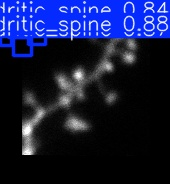

In [32]:
from IPython.display import Image, display

# Replace with a real filename from the list you just generated
image_path = "/content/runs/detect/predict/spine_image001230.jpg"

display(Image(filename=image_path))

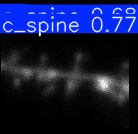

In [33]:
from IPython.display import Image, display

# Replace with a real filename from the list you just generated
image_path = "/content/runs/detect/predict/spine_image001797.jpg"

display(Image(filename=image_path))

--- Training Batch 0 ---


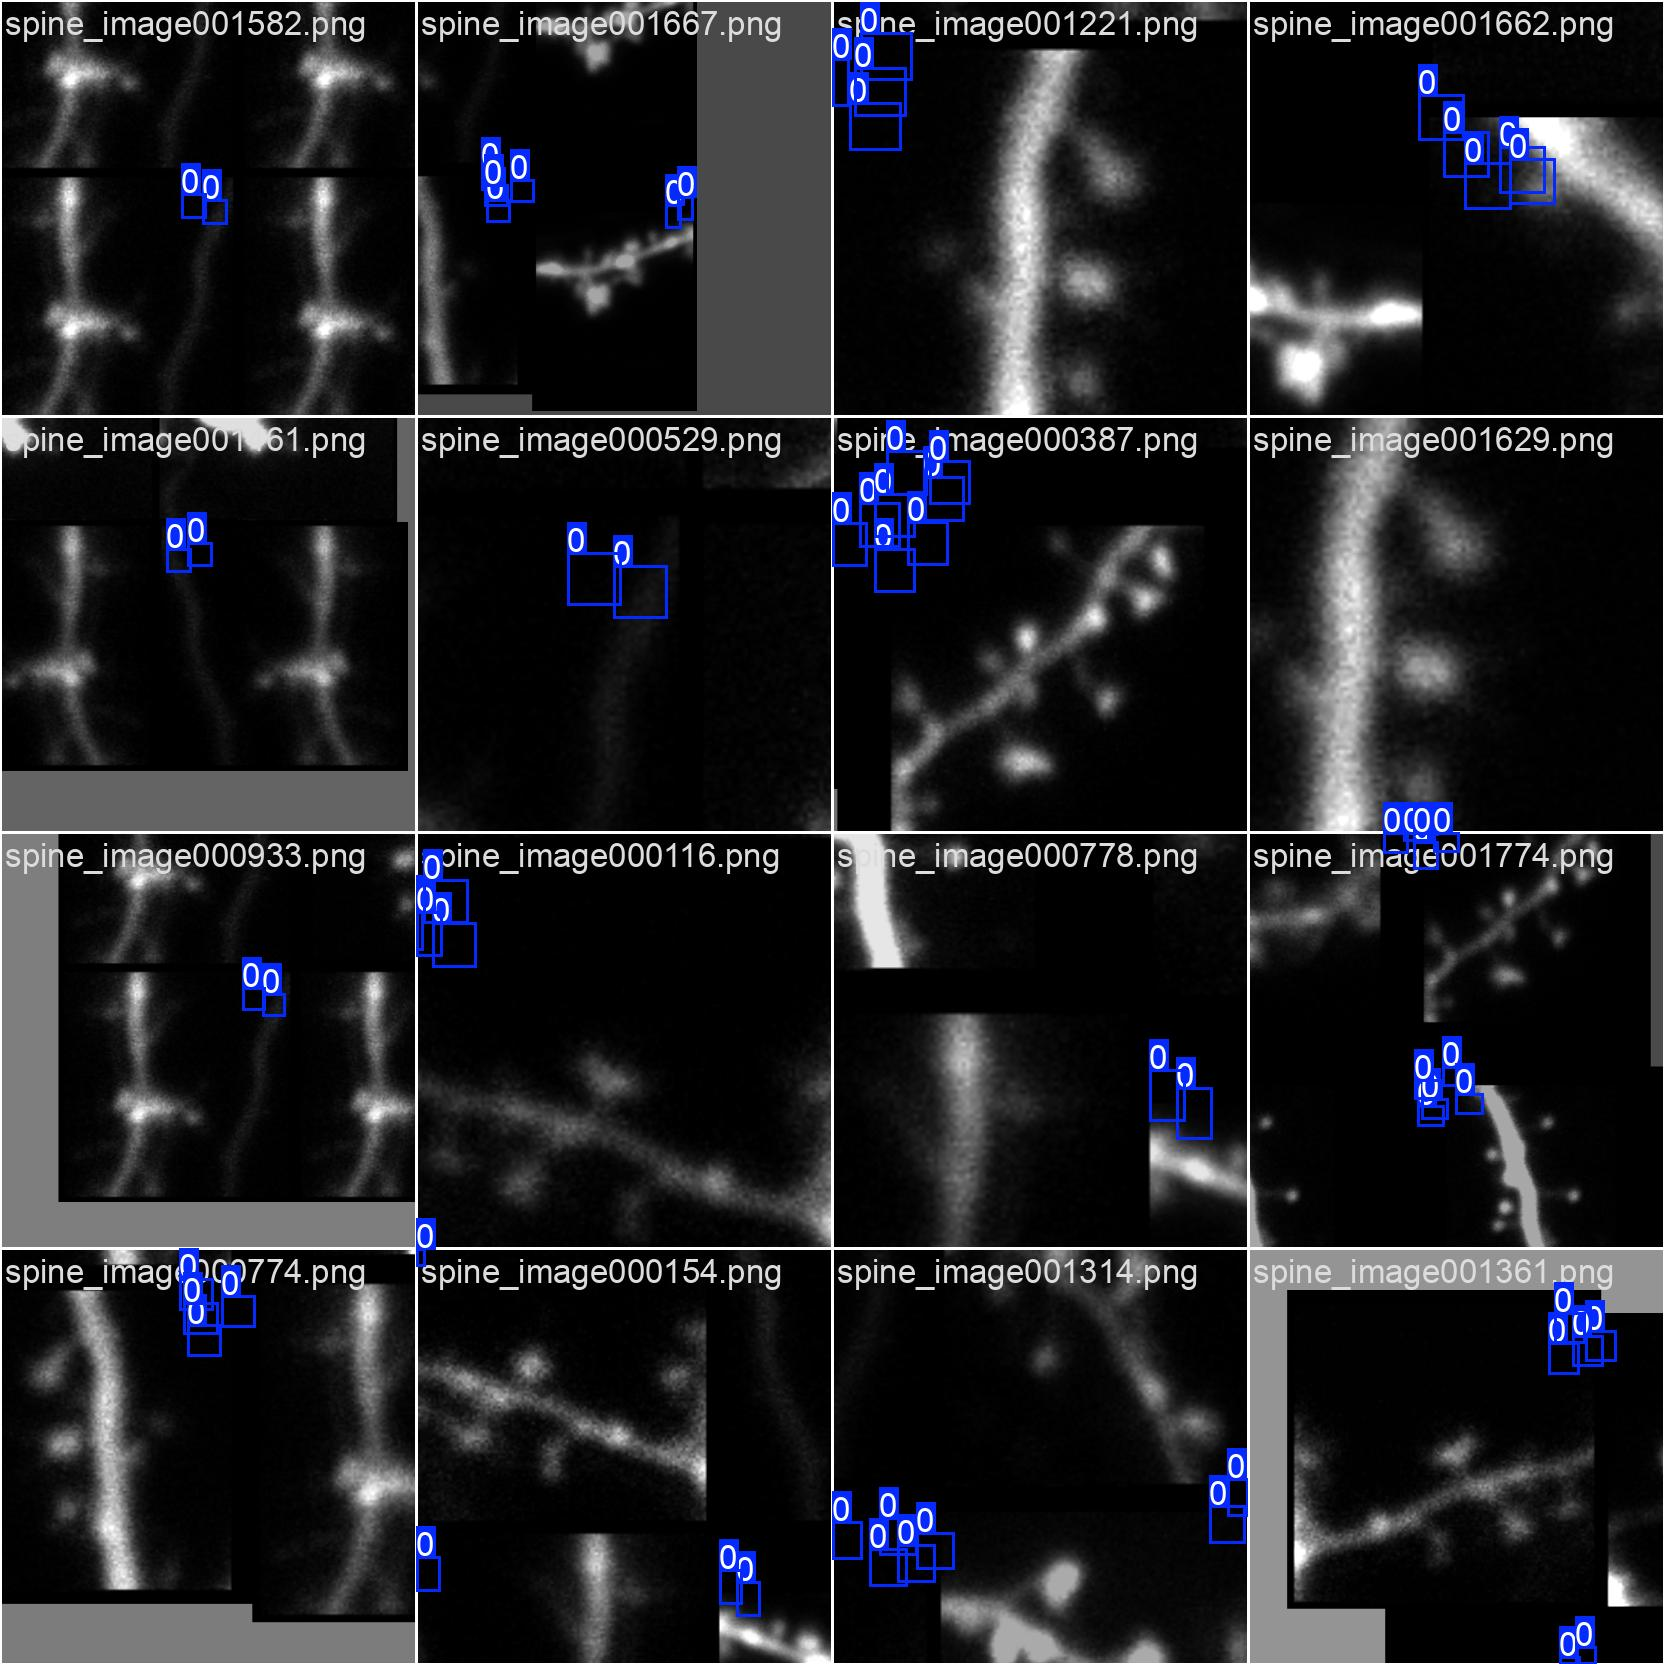

In [31]:
from IPython.display import Image, display

# Path to the first training batch image from your final run
image_path = "/content/DendriticSpineDetection/final_run/train_batch0.jpg"

print("--- Training Batch 0 ---")
display(Image(filename=image_path, width=1000))